# Libraries

In [357]:
source("tools.R")
library('DescTools')

# Plotting function

In [397]:
plot_lmls <- function(prop_data, title, real_world_data=c(), hide_x=FALSE, hide_y=FALSE) {
    
    # Real world data
    #points_data <- real_world_data %>% filter(scenario == title)
    #min_pd <- min(points_data$value)
    #max_pd <- max(points_data$value)
    #points_data <- points_data %>% filter(value == max_pd)
    
    plot <- prop_data %>%
                ggplot(aes(x=kernel, y=value)) + 
                    geom_bar(stat="identity") +
    
                    geom_bar(stat='identity', data=prop_data %>% filter(value == max(value)), alpha=0, size=0.5, color="red") +
    
                    coord_cartesian (ylim=c(0, 1)) +
                    labs(title = title) +
                    ggthemes::theme_few() +
                    xlab("Kernel composition") + 
                    ylab("Mean likelihood (scaled)") +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,                   
                                      position=position_dodge(.9)) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"),
                          plot.title = element_text(hjust = 0.5))# +
    
                    #Points (real-world data)
                    #geom_point(data=points_data, aes(y=value, x=kernel, group=kernel),
                    #               stat="identity", size=3, color="red", shape=18)
    
    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

# Prior likelihoods

### Preparing the data

In [401]:
data_prior <- read_csv("data/for_composititional_analysis_prior.csv")

dict_prior <- data_prior %>%                        
                        group_by(id, pid, scenario) %>%
                        summarize()

lmls_prior <- read_csv("output/lmls_prior.csv")

metadata_prior <- read_csv("output/metadata_prior.csv")

Parsed with column specification:
cols(
  cid = col_integer(),
  composition = col_character(),
  white_added = col_character(),
  second_exception = col_character()
)


In [402]:
metadata_prior <- metadata_prior %>%
                        mutate( cid_composition = paste0(cid, composition) )

metadata_prior$pid <- NULL
metadata_prior$composition <- NULL

kernels <- c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p")

lmls_prior<- lmls_prior %>% 
                gather(kernel, lml, kernels)

colnames(lmls_prior) = c('id', 'kernel', 'lml')

lmls_prior <- merge(x = lmls_prior, y = dict_prior, by = c("id", "id"), all.x = TRUE)

lmls_prior <- lmls_prior %>%
                        mutate( cid_composition = paste0(id, kernel) )

# Joining
lmls_prior <- merge(x = lmls_prior, y = metadata_prior, by = c("cid_composition", "cid_composition"), all.x = TRUE)
lmls_prior$cid_composition <- NULL

### Counting
Percentage of GPs that were filtered out (by any reason)

In [403]:
paste0(round((lmls_prior %>%
            filter(lml == -999999999 | second_exception == 'True' | lml <= -10000) %>%
            filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
            nrow) / 
(lmls_prior %>% 
     filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
     nrow) * 100, 2), '%')

[1] "7.22%"

### Summarising and plotting

In [404]:
# Removes the GPs that failed to be optimized in the second time. The lmls that failed to be optimized are also removed.
#Finaly, the lml_standard is calculated
lmls_prior_f <- lmls_prior %>%
                    filter(second_exception == 'False' & lml != -999999999) %>%
                    group_by(pid, scenario) %>%
                    mutate(lml_minus_min = lml - min(lml),
                           lml_standard = lml_minus_min / (max(lml_minus_min) - min (lml_minus_min)))

sds <- lmls_prior_f %>% 
            group_by(kernel, scenario) %>%
            summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

sds$ks <- paste0(sds$kernel, sds$scenario)

lmls_prior_f$ks <- paste0(lmls_prior_f$kernel, lmls_prior_f$scenario)

sds$kernel <- NULL
sds$scenario <- NULL

lmls_prior_f <- merge(x = lmls_prior_f, y = sds, by = "ks", all.x = TRUE)

In [405]:
normalize_bool = TRUE
plot_bool      = TRUE

to_plot_prior <- lmls_prior_f %>% 
            filter(lml > -10000) %>%
            filter(lml > lo_bound & lml < up_bound) %>%
            group_by(kernel, scenario) %>%
            summarize(value = mean(lml),
                      lo_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['lwr.ci'],
                      hi_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['upr.ci'])

# Remove single components
to_plot_prior <- to_plot_prior %>%
                filter(kernel != 'l', kernel != 'p', kernel != 'r')

# Scaling the 'data to plot' to a 0-1 range
min_v = min(to_plot_prior$value)
range_v = max(to_plot_prior$value) - min(to_plot_prior$value)

if(normalize_bool) {
    #Normalization
    to_plot_prior <- to_plot_prior %>%
                    group_by( scenario ) %>%
                    mutate( lo_ci = (lo_ci - min(value)) / (max(value) - min(value)),
                            hi_ci = (hi_ci - min(value)) / (max(value) - min(value)),  
                            value = (value - min(value)) / (max(value) - min(value)))
}

# Plotting magic
to_plot_prior$kernel <- factor(to_plot_prior$kernel, levels=kernels)

lmls_temperature <- to_plot_prior %>% filter(scenario == "Temperature")
lmls_rain <- to_plot_prior %>% filter(scenario == "Rain")
lmls_sales <- to_plot_prior %>% filter(scenario == "Sales")
lmls_gym <- to_plot_prior %>% filter(scenario == "Gym members")
lmls_salary <- to_plot_prior %>% filter(scenario == "Salary")
lmls_fb <- to_plot_prior %>% filter(scenario == "FB Friends")

# Real-world data
rwdata <- read_csv("data/real-world/to-plot.csv")

rwdata <- rwdata %>%
    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
    group_by(scenario) %>%
    mutate(value = (lml - min(lml)) / (max(lml) - min(lml)))


if (plot_bool) {
    # Plots
    p1 <- plot_lmls( lmls_temperature, "Temperature", real_world_data=rwdata, hide_x=TRUE)
    p2 <- plot_lmls( lmls_rain,        "Rain",        real_world_data=rwdata, hide_x=TRUE)
    p3 <- plot_lmls( lmls_sales,       "Sales",       real_world_data=rwdata, hide_x=TRUE, hide_y=TRUE)
    p4 <- plot_lmls( lmls_gym,         "Gym members", real_world_data=rwdata, hide_x=TRUE, hide_y=TRUE)
    p5 <- plot_lmls( lmls_salary,      "Salary",      real_world_data=rwdata, hide_x=TRUE, hide_y=TRUE)
    p6 <- plot_lmls( lmls_fb,          "FB Friends",  real_world_data=rwdata, hide_x=TRUE, hide_y=TRUE)

    pdf("Images/paper_images/kernels_priors_lmls_5sd.pdf", width=8, height=4)
    multiplot(p1, p2, p3, p4, p5, p6, cols=3)
    dev.off()   
}

Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)


png 
  2

### Prior condition. Best performing kernel compositions:

In [316]:
to_plot_prior %>%
    group_by(scenario) %>%
    summarize(kernel[which.max(value)], value[which.max(value)]) %>%
    arrange(scenarios_order(scenario))

scenario,kernel[which.max(value)],value[which.max(value)]
Temperature,p*r,443.1288
Rain,l+r*p,213.3836
Sales,l+r,-881.9682
Gym members,p+r,518.0173
Salary,p+r,809.7401
FB Friends,l+r,125.2687


In [317]:
# Which other kernel compositions are statistically equivalent
to_plot_prior %>%
    group_by(scenario) %>%
    filter(hi_ci > lo_ci[which.max(value)]) %>%
    select(scenario, kernel, value, lo_ci, hi_ci) %>%
    arrange(scenarios_order(scenario))

scenario,kernel,value,lo_ci,hi_ci
Temperature,l+r*p,378.94365,325.97647,433.9707
Temperature,p*r,443.12881,400.61238,488.6233
Rain,l+r,177.39997,108.91701,242.1932
Rain,l+r*p,213.38355,154.60898,270.2785
Rain,p*r,191.97564,126.90503,252.2169
Rain,p+r,80.67802,-42.93421,203.8476
Sales,l+r,-881.96818,-1004.50409,-765.9873
Sales,p+r,-1120.45873,-1332.57435,-922.5058
Gym members,l+r,358.30459,276.51743,429.5126
Gym members,l+r*p,486.23738,407.00822,563.7312


# Full-Bayesian Posterior analysis

### Preparing the data

In [318]:
lmls_posterior <- read_csv("output/full-bayesian-posterior/results_posterior_test_lmls.csv")

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_logical(),
  second_exception = col_logical()
)


In [319]:
# To add the 'scenario' column

data_posterior <- read_csv("data/for_composititional_analysis_posterior.csv")

dict_posterior <- data_posterior %>%                        
                        group_by(id, pid, scenario) %>%
                        summarize()

dict_posterior$pid <- NULL

lmls_posterior <- merge(x = lmls_posterior, y = dict_posterior, by = c("id", "id"), all.x = TRUE)

# Adding 'participant id' (pid)
lmls_posterior$pid <- floor((lmls_posterior$id-1) / 6) + 1

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


### Analyzing

In [362]:
print('White added')

lmls_posterior %>%
    filter(white_added == 'TRUE') %>%
    nrow

lmls_posterior %>%
    filter(white_added == 'FALSE') %>%
    nrow

lmls_posterior %>%
    nrow

#######

print('Second exception')
lmls_posterior %>%
    filter(second_exception == 'TRUE') %>%
    nrow

lmls_posterior %>%
    filter(second_exception == 'FALSE') %>%
    nrow

lmls_posterior %>%
    nrow

######

print('Proportion of LML error and Second exception over the total')

paste0(round((lmls_posterior %>%
            filter(lml == -999999999 | second_exception == 'True' | lml <= -10000) %>%
            filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
            nrow) / (lmls_posterior %>% 
                     filter(kernel != 'l', kernel != 'p', kernel != 'r') %>%
                     nrow) * 100, 2), '%')

[1] "White added"


[1] 3333

[1] 6663

[1] 9996

[1] "Second exception"


[1] 168

[1] 9828

[1] 9996

[1] "Proportion of LML error and Second exception over the total"


[1] "3.95%"

In [321]:
# Removing unusable data, and standardizing.
lmls_posterior_f <- lmls_posterior %>%
                    filter(second_exception == 'FALSE' & lml != -999999999) %>%
                    group_by(pid, scenario) %>%
                    mutate(lml_minus_min = lml - min(lml),
                           lml_standard = lml_minus_min / (max(lml_minus_min) - min (lml_minus_min)))

# Standard deviations calculation
sds <- lmls_posterior_f %>% 
            group_by(kernel, scenario) %>%
            summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

sds$ks <- paste0(sds$kernel, sds$scenario)

lmls_posterior_f$ks <- paste0(lmls_posterior_f$kernel, lmls_posterior_f$scenario)

sds$kernel <- NULL
sds$scenario <- NULL

lmls_posterior_f <- merge(x = lmls_posterior_f, y = sds, by = "ks", all.x = TRUE)

### Plotting

In [322]:
normalize_bool = FALSE
plot_bool      = FALSE

# Plotting data
to_plot_posterior <- lmls_posterior_f %>%
            filter(lml > -10000) %>%
            filter(lml > lo_bound & lml < up_bound) %>%
            group_by(kernel, scenario) %>%
            summarize(value = mean(lml),
                      lo_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['lwr.ci'],
                      hi_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['upr.ci'])

# Remove single components
to_plot_posterior <- to_plot_posterior %>%
                filter(kernel != 'l', kernel != 'p', kernel != 'r')

# Scaling the 'data to plot' to a 0-1 range
min_v = min(to_plot_posterior$value)
range_v = max(to_plot_posterior$value) - min(to_plot_posterior$value)

if(normalize_bool){
    # Normalization
    to_plot_posterior <- to_plot_posterior %>%
                    group_by( scenario ) %>%
                    mutate( lo_ci = (lo_ci - min(value)) / (max(value) - min(value)),
                            hi_ci = (hi_ci - min(value)) / (max(value) - min(value)),  
                            value = (value - min(value)) / (max(value) - min(value)))  
}

# Plotting magic
to_plot_posterior$kernel <- factor(to_plot_posterior$kernel, levels=kernels)

lmls_temperature <- to_plot_posterior %>% filter(scenario == "Temperature")
lmls_rain <- to_plot_posterior %>% filter(scenario == "Rain")
lmls_sales <- to_plot_posterior %>% filter(scenario == "Sales")
lmls_gym <- to_plot_posterior %>% filter(scenario == "Gym members")
lmls_salary <- to_plot_posterior %>% filter(scenario == "Salary")
lmls_fb <- to_plot_posterior %>% filter(scenario == "FB Friends")

if (plot_bool){
    p1 <- plot_lmls(lmls_temperature, "Temperature", hide_x=TRUE)
    p2 <- plot_lmls(lmls_rain, "Rain", hide_x=TRUE)
    p3 <- plot_lmls(lmls_sales, "Sales", hide_x=TRUE, hide_y=TRUE)
    p4 <- plot_lmls(lmls_gym, "Gym members", hide_y=TRUE, hide_x=TRUE)
    p5 <- plot_lmls(lmls_salary, "Salary", hide_x=TRUE, hide_y=TRUE)
    p6 <- plot_lmls(lmls_fb, "FB Friends", hide_y=TRUE, hide_x=TRUE)

    pdf("Images/paper_images/kernels_posteriors_lmls_5sd.pdf", width=8, height=4)
    multiplot(p1, p2, p3, p4, p5, p6, cols=3)
    dev.off()
}

In [323]:
# Which kernel is max
to_plot_posterior %>%
    group_by(scenario) %>%
    summarize(kernel[which.max(value)], value[which.max(value)], lo_ci[which.max(value)]) %>%
    arrange(scenarios_order(scenario))

scenario,kernel[which.max(value)],value[which.max(value)],lo_ci[which.max(value)]
Temperature,l+r,71.61679,56.36980
Rain,l+r,38.23271,24.04080
Sales,l*r,-327.82386,-338.91398
Gym members,p+r,65.25972,42.87288
Salary,p+r,21.91297,-9.65624
FB Friends,l*r*p,-217.16590,-230.11637


In [324]:
# Which other kernel compositions are statistically equivalent
to_plot_posterior %>%
    group_by(scenario) %>%
    filter(hi_ci > lo_ci[which.max(value)]) %>%
    select(scenario, kernel, value, lo_ci, hi_ci) %>%
    arrange(scenario) %>%
    arrange(scenarios_order(scenario))

scenario,kernel,value,lo_ci,hi_ci
Temperature,l*r+p,37.792666,17.369631,57.94446
Temperature,l+r,71.616794,56.369801,88.09726
Temperature,l+r+p,59.046143,37.376780,80.41095
Temperature,p+r,40.546092,-47.317092,125.93049
Rain,l+r,38.232710,24.040797,51.01730
Rain,p+r,2.657068,-22.755812,27.71180
Sales,l*r,-327.823858,-338.913983,-316.38363
Sales,l*r*p,-330.058398,-349.039047,-310.95411
Sales,l*r+p,-336.614088,-352.466929,-320.25456
Gym members,l+r,38.068292,17.365123,58.40361


# Best on each condition

In [325]:
lmls_prior_ff <- lmls_prior_f %>%
                    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>% 
                    filter(lml > lo_bound & lml < up_bound) %>%
                    filter(lml > -10000)

lmls_posterior_ff <- lmls_posterior_f %>%
                    filter(kernel != 'l', kernel != 'p', kernel != 'r') %>% 
                    filter(lml > lo_bound & lml < up_bound) %>%
                    filter(lml > -10000)

### Averages

In [326]:
prior_a <- lmls_prior_ff %>%
                    group_by(kernel, scenario) %>%
                    summarize(value = mean(lml),
                              lo_ci = t.test(lml, conf.level=0.95)$conf.int[1],
                              hi_ci = t.test(lml, conf.level=0.95)$conf.int[2])

posterior_a <- lmls_posterior_ff %>%
                    group_by(kernel, scenario) %>%
                    summarize(value = mean(lml),
                              lo_ci = t.test(lml, conf.level=0.95)$conf.int[1],
                              hi_ci = t.test(lml, conf.level=0.95)$conf.int[2])

### Tables

In [327]:
prior_a %>% 
    group_by(scenario) %>%
    summarize(max_index = which.max(value),
              max_kernel = kernel[max_index],
              max_lml = value[max_index]) %>%
    arrange(scenarios_order(scenario))

scenario,max_index,max_kernel,max_lml
Temperature,10,p*r,443.1288
Rain,8,l+r*p,213.3836
Sales,7,l+r,-881.9682
Gym members,11,p+r,518.0173
Salary,11,p+r,809.7401
FB Friends,7,l+r,125.2687


In [328]:
posterior_a %>% 
    group_by(scenario) %>%
    summarize(max_index = which.max(value),
              max_kernel = kernel[max_index],
              max_lml = value[max_index]) %>%
    arrange(scenarios_order(scenario))

scenario,max_index,max_kernel,max_lml
Temperature,7,l+r,71.61679
Rain,7,l+r,38.23271
Sales,3,l*r,-327.82386
Gym members,11,p+r,65.25972
Salary,11,p+r,21.91297
FB Friends,4,l*r*p,-217.16590


### Consistency

In [329]:
prior_maxs <- lmls_prior_f %>%
                        filter(kernel != 'l', kernel != 'p', kernel != 'r') %>% 
                        group_by(id, pid, scenario) %>%
                        summarize(max_index = which.max(lml),
                                  max_kernel = kernel[max_index],
                                  max_lml = lml[max_index])

In [330]:
posterior_maxs <- lmls_posterior_f %>%
                        filter(kernel != 'l', kernel != 'p', kernel != 'r') %>% 
                        group_by(id, pid, scenario) %>%
                        summarize(max_index = which.max(lml),
                                  max_kernel = kernel[max_index],
                                  max_lml = lml[max_index])

In [331]:
merged_maxs <- merge(x = prior_maxs, y = posterior_maxs, by = c("id", "id")) #inner join

Percentage of consistency (match):

In [332]:
merged_maxs <- merged_maxs %>%
    mutate(match = (max_kernel.x == max_kernel.y))

In [333]:
(( merged_maxs %>%
     filter(match == TRUE) %>%
     nrow) /
 ( merged_maxs %>%
     nrow) ) %>% round(2)

[1] 0.23

Chance:

In [334]:
(1/11) %>% round(2)

[1] 0.09

Bootstrapped confidence interval (for binomial distribution):

In [336]:
bp = function(x, lev, n = 1e6, alpha=0.05) {
  res = replicate(n, sum(sample(x, length(x), replace=TRUE) == lev)/length(x))
  return(list(mean=mean(res),
              `95% CI`=quantile(res, c(0.5*alpha,1-0.5*alpha))))
}

bp2 = function(vector) {
    
    match_ci <- bp(vector$match, TRUE)
    
    return( c( match_ci$mean %>% round(2),
             match_ci$`95% CI`[1] %>% round(2),
             match_ci$`95% CI`[2] %>% round(2) ))
}

In [337]:
bp2(merged_maxs)

2.5% 97.5% 
 0.23  0.19  0.26

### Consistency per POSTERIOR condition

In [338]:
#Importing the relevant data
aux <- read_csv("data/for_composititional_analysis_posterior.csv")

posterior_conditions <- aux %>% select(id, condition) %>% unique

# Merging
merged_maxs <- merge(x = merged_maxs, y = posterior_conditions, by = c("id", "id"))

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


In [339]:
bp3 = function(condition) {
    print(condition)
    merged_maxs %>%
        filter(condition == condition) %>%
        bp2 %>%
        print
}

In [340]:
print('All')
print(bp2(merged_maxs))

print('Posterior-Positive')
    merged_maxs %>%
        filter(condition == 'Posterior-Positive') %>%
        bp2 %>%
        print

print('Posterior-Stable')
    merged_maxs %>%
        filter(condition == 'Posterior-Stable') %>%
        bp2 %>%
        print

print('Posterior-Negative')
    merged_maxs %>%
        filter(condition == 'Posterior-Negative') %>%
        bp2 %>%
        print

[1] "All"
       2.5% 97.5% 
 0.23  0.19  0.26 
[1] "Posterior-Positive"
       2.5% 97.5% 
 0.24  0.18  0.29 
[1] "Posterior-Stable"
       2.5% 97.5% 
 0.22  0.17  0.27 
[1] "Posterior-Negative"
       2.5% 97.5% 
 0.22  0.17  0.27 


In [341]:
bp3 = function(data, filter_v, condition = TRUE){
    
    if(condition){
        results <- data %>%
                    filter(condition == !!filter_v) %>%
                    bp2 
    }
    else {
        results <- data %>%
                    filter(scenario.x == !!filter_v) %>%
                    bp2 
    }
    
    data.frame(list( condition = filter_v, 
                     mean  = results[[1]], 
                     lo_ci = results[[2]],
                     hi_ci = results[[3]]))
}

In [342]:
plot_consistence = function(consistence_data, title, xlab, ylim_hi=0.45, ylab="Proportion of Match")
    consistence_data %>%
                ggplot(aes(x=condition, y=mean)) + 
                    geom_bar(stat="identity", aes(fill = fill)) +
                    scale_fill_manual(values=c("grey35", "black")) +
                    coord_cartesian (ylim=c(0, ylim_hi)) +
                    labs(title = title) +
                    ggthemes::theme_few() +
                    theme(legend.position="none") +
                    xlab(xlab) + 
                    ylab(ylab) +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,                   
                                      position=position_dodge(.9)) +
                    theme(#axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"),
                          plot.title = element_text(hjust = 0.5)) +
                    geom_hline(yintercept = 1/11, linetype="dashed") #chance value

In [343]:
chance <- data.frame(list(condition="Chance", mean=1/11, lo_ci=1/13, hi_ci=1/12)) #the confidence interval is set in lower values for it to disappear

consistence_condition <- rbind( #chance,
                                bp3(merged_maxs, "Posterior-Positive"),
                                bp3(merged_maxs, "Posterior-Stable"),
                                bp3(merged_maxs, "Posterior-Negative"))

consistence_scenario <- rbind(  #chance,
                                bp3(merged_maxs, "Temperature", FALSE),
                                bp3(merged_maxs, "Rain", FALSE),
                                bp3(merged_maxs, "Sales", FALSE),
                                bp3(merged_maxs, "Gym members", FALSE),
                                bp3(merged_maxs, "Salary", FALSE),
                                bp3(merged_maxs, "FB Friends", FALSE))

In [344]:
#Extend the text so the plots match in size
longer_text <- "FB Friends             "

levels(consistence_scenario$condition) <- c(levels(consistence_scenario$condition), longer_text)

#consistence_scenario[7,1] <- longer_text

In [345]:
# Add this for colors
consistence_condition$fill <- (consistence_condition$condition == "Chance")
consistence_scenario$fill <- (consistence_scenario$condition == "Chance")

In [346]:
# Readable names of Posterior conditions
levels(consistence_condition$condition) <- c(levels(consistence_condition$condition), "Positive", "Stable", "Negative")

# Replacement
consistence_condition[consistence_condition$condition == "Posterior-Positive", "condition"] <- "Positive"
consistence_condition[consistence_condition$condition == "Posterior-Stable", "condition"] <- "Stable"
consistence_condition[consistence_condition$condition == "Posterior-Negative", "condition"] <- "Negative"

In [347]:
# Readable Gym
levels(consistence_scenario$condition) <- c(levels(consistence_scenario$condition), "Gym")
consistence_scenario[consistence_scenario$condition == "Gym members", "condition"] <- "Gym"

levels(consistence_scenario$condition) <- c(levels(consistence_scenario$condition), "FB friends")
consistence_scenario[consistence_scenario$condition == "FB Friends", "condition"] <- "FB friends"

In [363]:
plot_cond <- consistence_condition %>% plot_consistence(title="(a)", xlab="Posterior conditions")

plot_scen <- consistence_scenario %>% plot_consistence(title="(b)", xlab="Scenarios")

pdf("Images/paper_images/match_proportion.pdf", width=4, height=6)
multiplot(plot_cond, plot_scen, cols=1)
dev.off()  

png 
  2

# Match index

In [349]:
# Which other kernel compositions are statistically equivalent
best_prior <- to_plot_prior %>%
    group_by(scenario) %>%
    filter(hi_ci > lo_ci[which.max(value)]) %>%
    select(scenario, kernel, value, lo_ci, hi_ci) %>%
    arrange(scenario)

# Which other kernel compositions are statistically equivalent
best_posterior <- to_plot_posterior %>%
    group_by(scenario) %>%
    filter(hi_ci > lo_ci[which.max(value)]) %>%
    select(scenario, kernel, value, lo_ci, hi_ci) %>%
    arrange(scenario)

In [351]:
# Inner join
inner_aux <- merge(x = best_prior, y = best_posterior, by.x = c('scenario', 'kernel'), by.y = c('scenario', 'kernel')) %>%
                    group_by(scenario) %>%
                    summarize(count = length(kernel))

In [352]:
# Outer join
outer_aux <- merge(x = best_prior, y = best_posterior, by.x = c('scenario', 'kernel'), by.y = c('scenario', 'kernel'), all.x=TRUE, all.y=TRUE) %>%
                    group_by(scenario) %>%
                    summarize(count = length(kernel))

In [353]:
merge(inner_aux, outer_aux, by='scenario') %>%
    mutate(match = round(count.x/count.y, 2))

scenario,count.x,count.y,match
Gym members,2,5,0.4
Rain,2,4,0.5
Salary,2,5,0.4


# Ranking correlation

In [354]:
# This is the participants data, in the Prior condition. 
# We are filtering LML lower than -10.000, and out of the 5 standardad deviations. Failed GPs have already been filtered
lmls_prior_f %>%
            filter(lml > -10000) %>%
            filter(lml > lo_bound & lml < up_bound) %>%
            head

ks,id,kernel,lml,pid,scenario,cid,white_added,second_exception,lml_minus_min,lml_standard,lo_bound,up_bound
l*p+rFB Friends,498,l*p+r,-1.768597e+03,a083,FB Friends,498,False,False,103.2890,0.04521479,-29994.07,26220.81
l*p+rFB Friends,126,l*p+r,-1.546767e+03,a021,FB Friends,126,False,False,576.9258,0.36813021,-29994.07,26220.81
l*p+rFB Friends,354,l*p+r,5.798369e+01,a059,FB Friends,354,True,False,1832.0332,0.74694955,-29994.07,26220.81
l*p+rFB Friends,294,l*p+r,-6.412404e-02,a049,FB Friends,294,False,False,1620.2027,0.83618118,-29994.07,26220.81
l*p+rFB Friends,642,l*p+r,-2.248445e+02,a108,FB Friends,642,True,False,1372.1776,0.66121756,-29994.07,26220.81
l*p+rFB Friends,210,l*p+r,-1.420681e+03,a035,FB Friends,210,False,False,534.5359,0.27830906,-29994.07,26220.81


In [412]:
# Real world data
rwdata <- read_csv("data/real-world/to-plot.csv")

Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)


In [492]:
fb %>%
    filter(year_month >= '2016 06') %>%
    head

id,year,month,added,Trimester_n,Trimester,year_month,accum
105,2016,6,12,2,2016-2,2016 06,584
106,2016,7,27,3,2016-3,2016 07,611
107,2016,8,15,3,2016-3,2016 08,626
108,2016,9,38,3,2016-3,2016 09,664
109,2016,10,10,4,2016-4,2016 10,674
110,2016,11,9,4,2016-4,2016 11,683


Parsed with column specification:
cols(
  id = col_integer(),
  year = col_integer(),
  month = col_integer(),
  added = col_integer(),
  Trimester_n = col_integer(),
  Trimester = col_character()
)


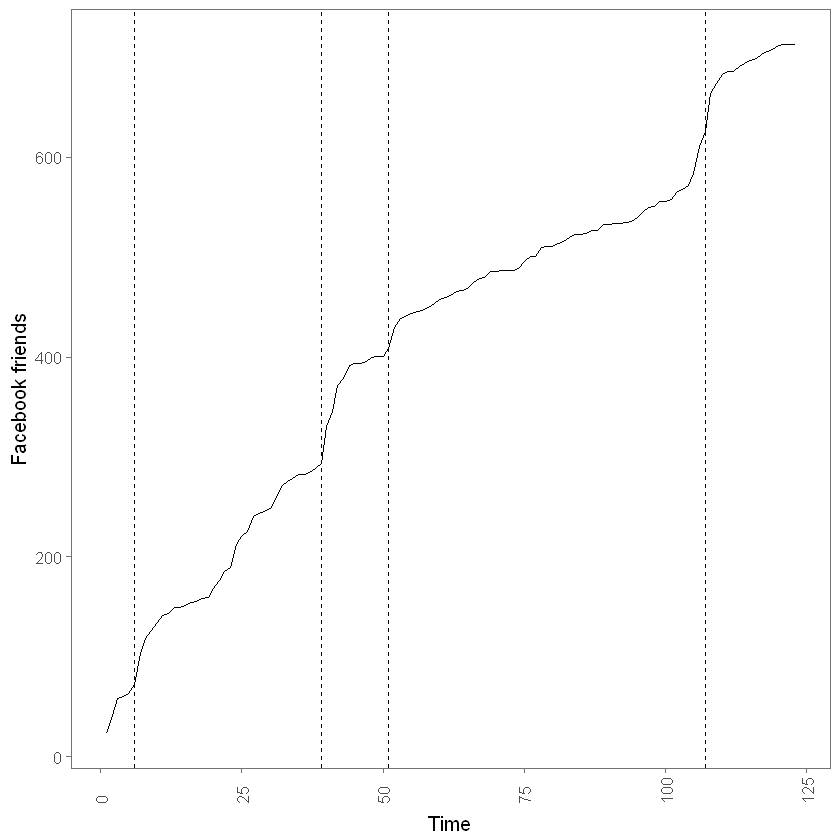

In [495]:
fb <- read_csv ('data/real-world/3- for_compositional_analysis/facebook_qv.csv')

fb$year_month <- ifelse(nchar(fb$month) == 1,
                           paste0(fb$year, ' 0', fb$month), 
                           paste0(fb$year,  ' ', fb$month))

fb <- within(fb, accum <- cumsum(added))

fb %>%
    ggplot(aes(x=id, y=accum, group=1)) + geom_line() +
    ggthemes::theme_few() +
    xlab("Time") + 
    ylab("Facebook friends") +
    geom_vline(xintercept = c(6, 39, 51, 107), linetype="dashed") +
    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0))


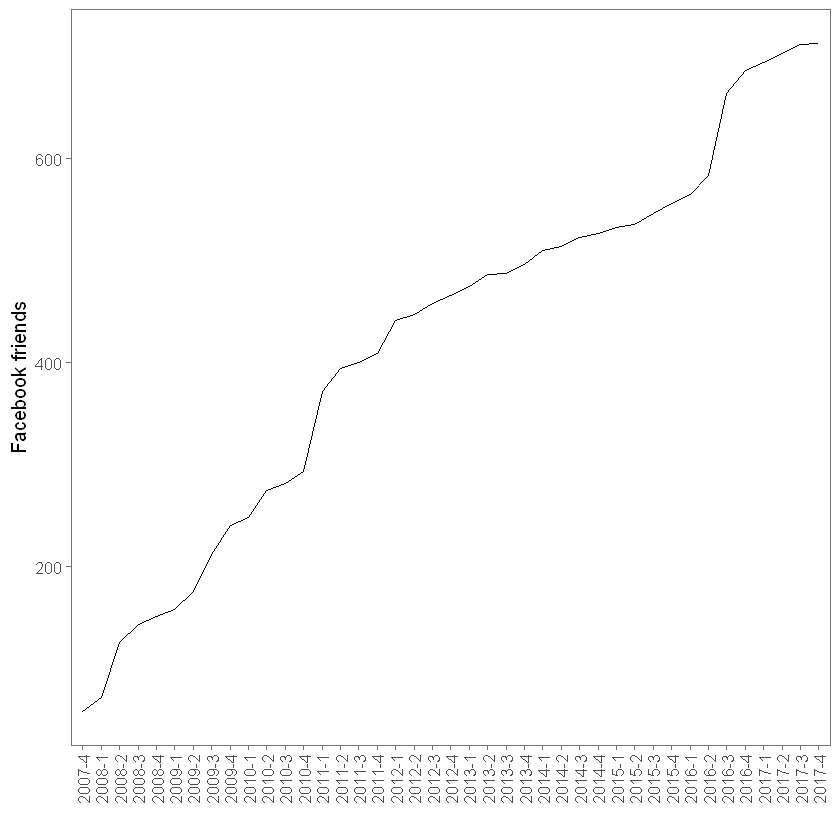